In [25]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
import plotly
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=True)

### path 추가

In [26]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
check_path = os.path.join(strategy_path, 'check')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from EEM import EEM
from EDY import EDY
from EFX import EFX
from ELQ import ELQ
from EPE import EPE
from EQL import EQL
from EPM import EPM
from ESS import ESS
from EST import EST
from EVO import EVO

In [28]:
eindex_path = os.path.join(data_path, 'totindex.csv')
eindex1_path = os.path.join(data_path, 'priceindex.csv')
efuture_path = os.path.join(data_path, 'FutGenratio1.CSV')

eindex = pd.read_csv(eindex_path, header=0, index_col=0, parse_dates=True)
eindex1 = pd.read_csv(eindex1_path, header=0, index_col=0, parse_dates=True)
efut = pd.read_csv(efuture_path, header=0, index_col=0, parse_dates=True)

eindex1 = eindex1.loc[:'2008']
ERetp = eindex1.pct_change(1).iloc[1:]
ERett = eindex.pct_change(1).iloc[1:]
fRet = efut.pct_change(1).iloc[1:]

compRet = ERett
compRet[compRet.isna()] = ERetp[compRet.isna()]
ERet1 = compRet
ERet1.drop_duplicates(inplace=True)
fRet.drop_duplicates(inplace=True)
ERet = pd.concat([ERet1.loc[:'2007-12-31'], fRet.loc['2008-01-01':]], axis=0)
ERet = ERet.fillna(0)
Eindex = (1 + ERet).cumprod()
Eindex = Eindex / Eindex.iloc[0]

# 1. EEM

- 각 전략에서 main 함수 부분을 가져오면 됩니다. 데이터가 다운이 받아져있으면 from_db = False로 하면 더 빠르게 테스트를 진행할 수 있습니다.

In [7]:
eem = EEM(strategy_name="EEM", asset_type="EQUITY")
eem.load_index_and_return(from_db=True, save_file=True) # from_db=False
eem.load_strategy_data(table='datastream', origin='ERR')
eem.set_rebalance_period(ts_freq='month', cs_freq='month')
eem.calculate_signal(minobs1=12, nopos=0.4, CS=0.35, longlen=12, shortlen=6, lag=0)
eem.set_portfolio_parameter(cs_strategy_type='notional')
eem.make_portfolio()

2020-01-22 14:56:36,523 - EEM - INFO - [STEP 0] START LOGGING EEM
2020-01-22 14:56:36,523 - EEM - INFO - [STEP 0] START LOGGING EEM
2020-01-22 14:56:36,526 - EEM - INFO - [STEP 1] LOAD DATA
2020-01-22 14:56:36,526 - EEM - INFO - [STEP 1] LOAD DATA
2020-01-22 14:56:36,528 - EEM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-01-22 14:56:36,528 - EEM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-01-22 14:56:36,531 - EEM - INFO - [STEP 1 - 3 ] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-01-22 14:56:36,531 - EEM - INFO - [STEP 1 - 3 ] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-01-22 14:56:39,409 - EEM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-01-22 14:56:39,409 - EEM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-01-22 14:56:40,994 - EEM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-01-22 14:56:40,994 - EEM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-01-22 14:57:12,940 - EEM - INFO - [STEP 1 -

### PAST

In [10]:
start_date = '2001-01-01'
end_date = '2018-05-09'

# get r results
eem_comp_df = pd.read_csv('./past/eem.csv', header=0, index_col=0, parse_dates=True)
eem_lag_comp_df = pd.read_csv('./past/eem_lag.csv', header=0, index_col=0, parse_dates=True)

- save_path를 check_path로 해주면 check 폴더에 각 전략별 성과 및 PLOT이 저장됩니다.

In [11]:
tester = Tester(eem)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False)

2020-01-22 15:00:21,258 - EEM - INFO - [STEP 6] START BACKTEST
2020-01-22 15:00:21,258 - EEM - INFO - [STEP 6] START BACKTEST
2020-01-22 15:00:21,260 - EEM - INFO - [STEP 6 - 1] BACKTEST EEM TIME SERIES
2020-01-22 15:00:21,260 - EEM - INFO - [STEP 6 - 1] BACKTEST EEM TIME SERIES


EEM
0% [############################# ] 100% | ETA: 00:00:00

2020-01-22 15:00:29,442 - EEM - INFO - [STEP 6 - 2] BACKTEST EEM CROSS SECTIONAL
2020-01-22 15:00:29,442 - EEM - INFO - [STEP 6 - 2] BACKTEST EEM CROSS SECTIONAL


EEM
0% [############################# ] 100% | ETA: 00:00:00

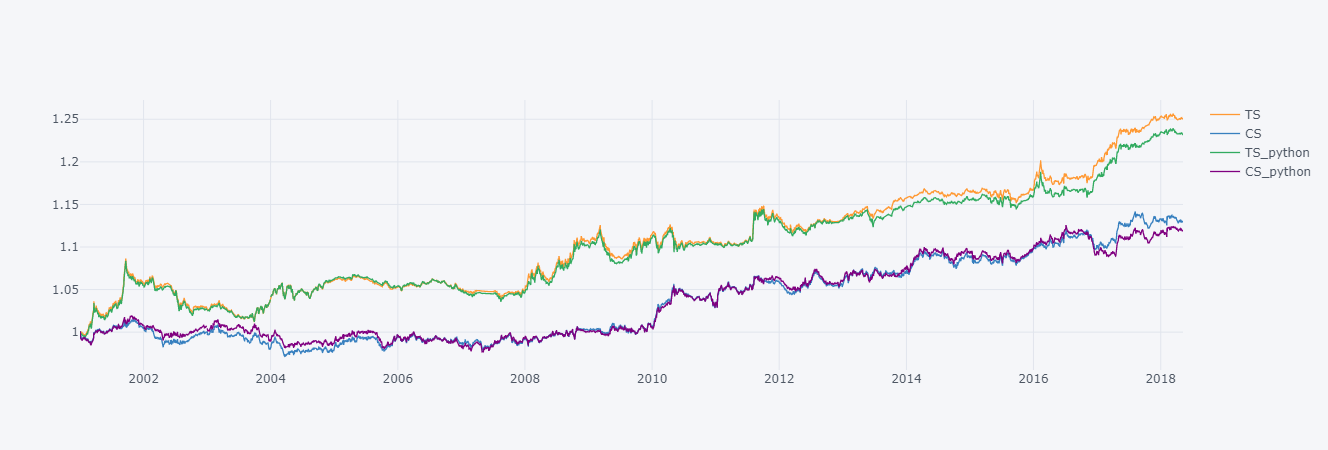

In [12]:
to_plot = (1.+ eem_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# 2. EDY

In [13]:
edy = EDY(strategy_name="EDY", asset_type="EQUITY")
edy.load_index_and_return(from_db=True, save_file=True)
edy.load_strategy_data1(table='DS', origin1='DPS', origin2='DPS1')
edy.load_strategy_data2(table='bloom', origin='10Yield')
edy.set_rebalance_period(ts_freq='month', cs_freq='month')
edy.calculate_signal(minobs1=12, nopos=0.4, CS=0.35)
edy.set_portfolio_parameter(cs_strategy_type='notional')
edy.make_portfolio()

2020-01-22 15:00:44,258 - EDY - INFO - [STEP 0] START LOGGING EDY
2020-01-22 15:00:44,260 - EDY - INFO - [STEP 1] LOAD DATA
2020-01-22 15:00:44,261 - EDY - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-01-22 15:00:44,264 - EDY - INFO - [STEP 1 - 3 ] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-01-22 15:00:47,697 - EDY - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-01-22 15:00:50,918 - EDY - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-01-22 15:01:30,892 - EDY - INFO - [STEP 1 - 4] SAVE RETURN DATA INTO CSV FORMAT
2020-01-22 15:01:40,206 - EDY - INFO - [STEP 2] SET REBALANCE PERIOD
/home/user01/Documents/dev/git_riskpremia/ver4/risk_premia/python/strategy/EDY.py:113: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike

/h

### PAST

In [21]:
start_date = '2006-01-01'
end_date = '2018-05-09'

# get r results
edy_comp_df = pd.read_csv('./past/edy.csv', header=0, index_col=0, parse_dates=True)
edy_lag_comp_df = pd.read_csv('./past/edy_lag.csv', header=0, index_col=0, parse_dates=True)

In [15]:
tester = Tester(edy)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False)

2020-01-22 15:03:06,740 - EDY - INFO - [STEP 6] START BACKTEST
2020-01-22 15:03:06,741 - EDY - INFO - [STEP 6 - 1] BACKTEST EDY TIME SERIES


EDY
0% [############################# ] 100% | ETA: 00:00:00

2020-01-22 15:03:13,931 - EDY - INFO - [STEP 6 - 2] BACKTEST EDY CROSS SECTIONAL


EDY
0% [############################# ] 100% | ETA: 00:00:00

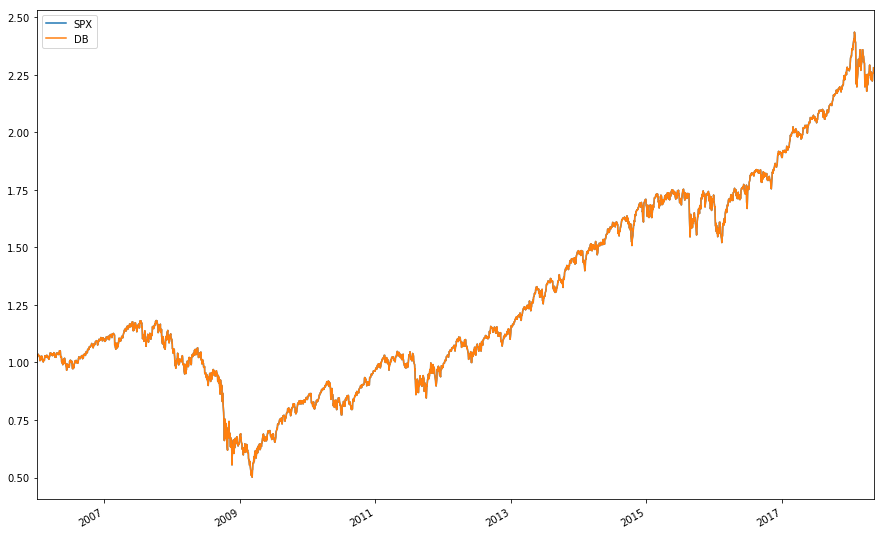

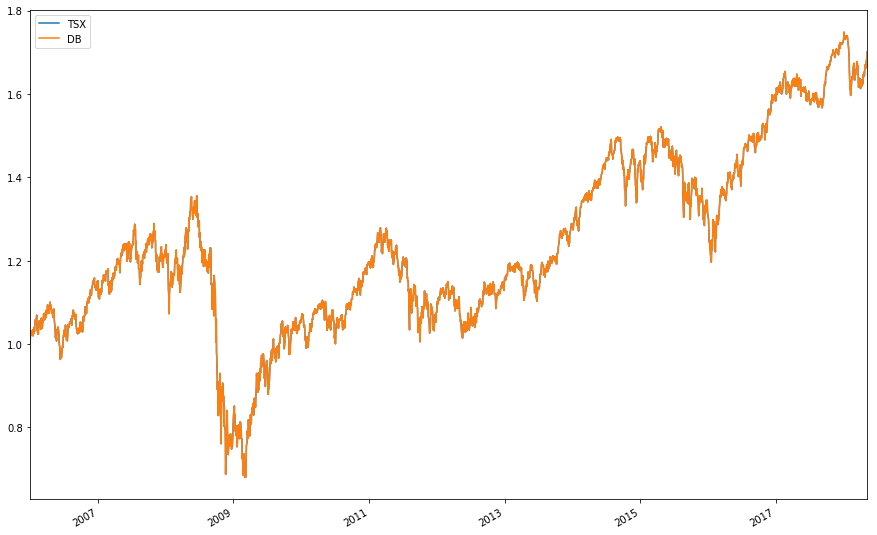

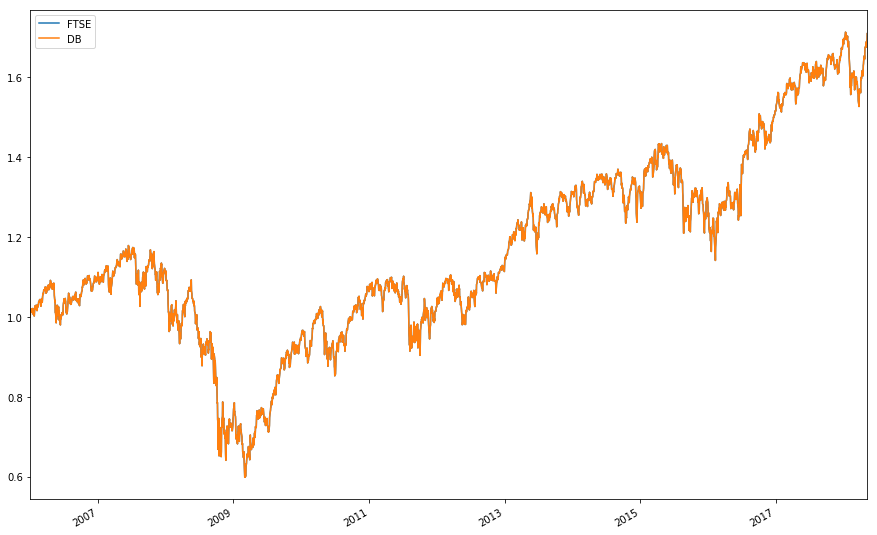

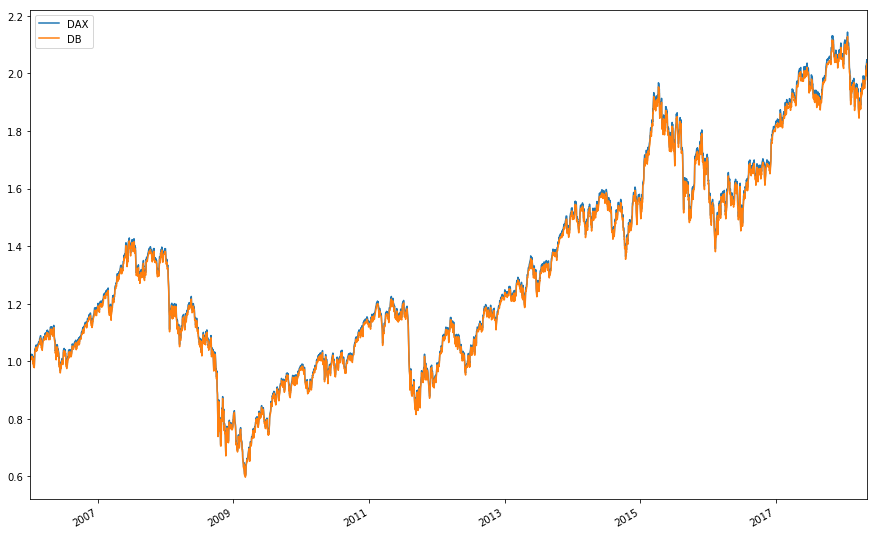

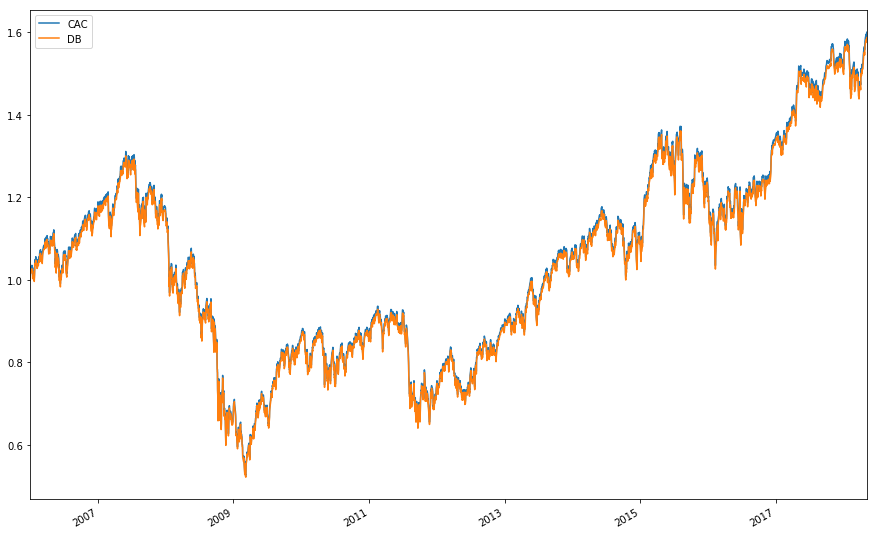

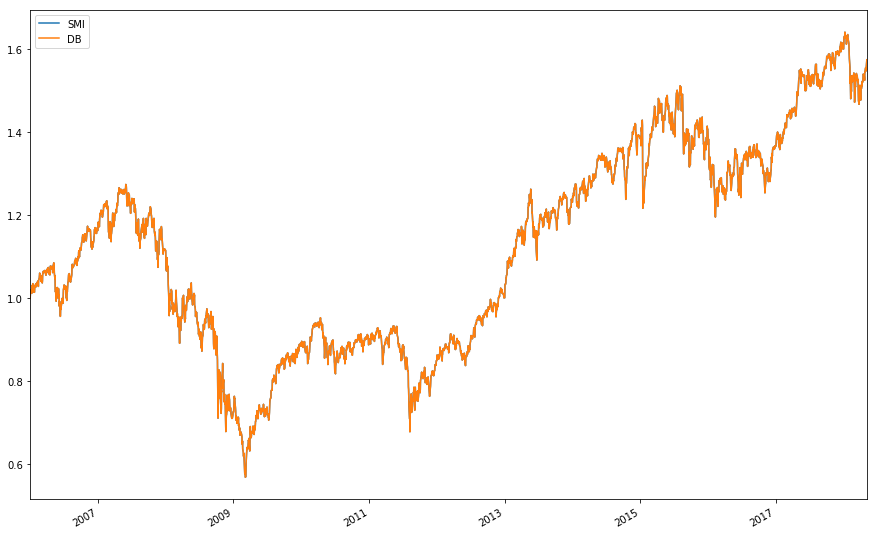

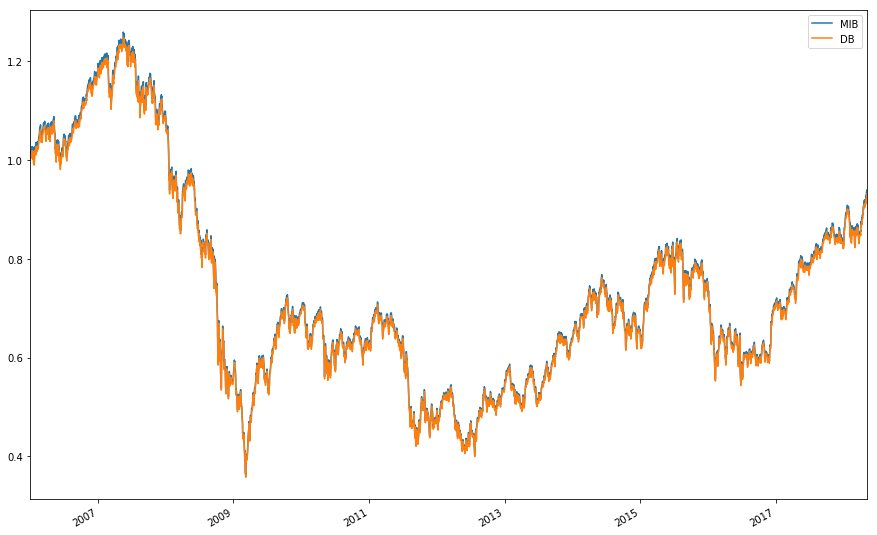

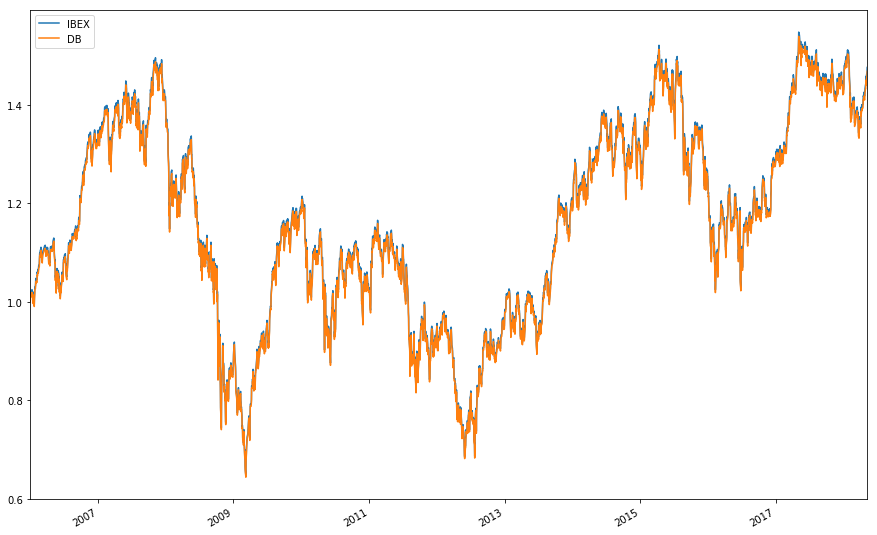

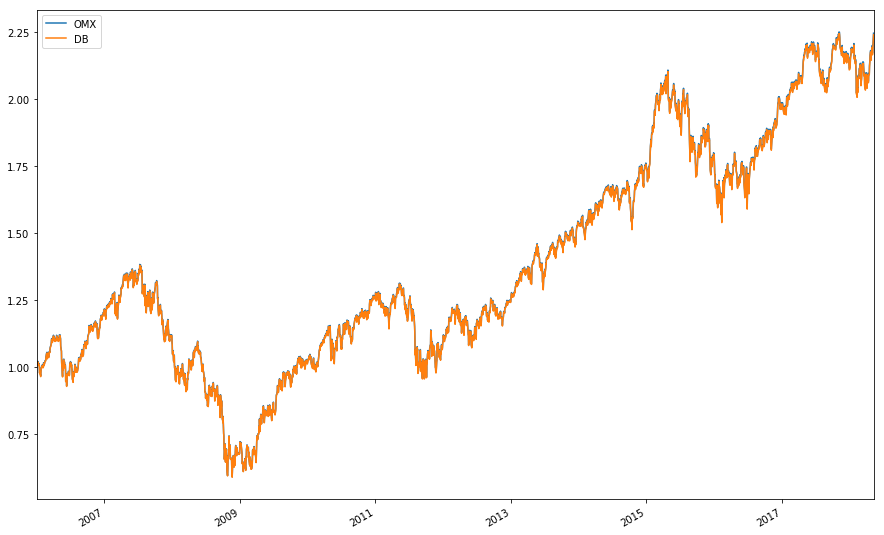

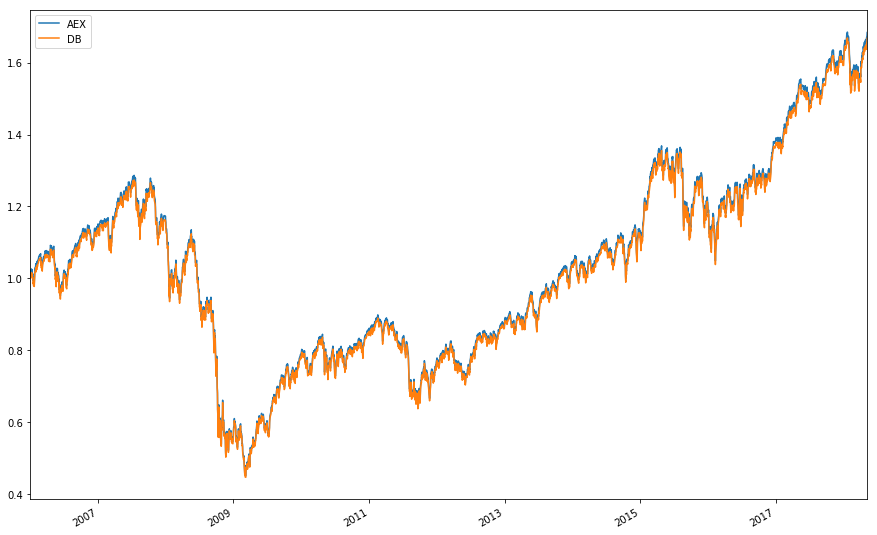

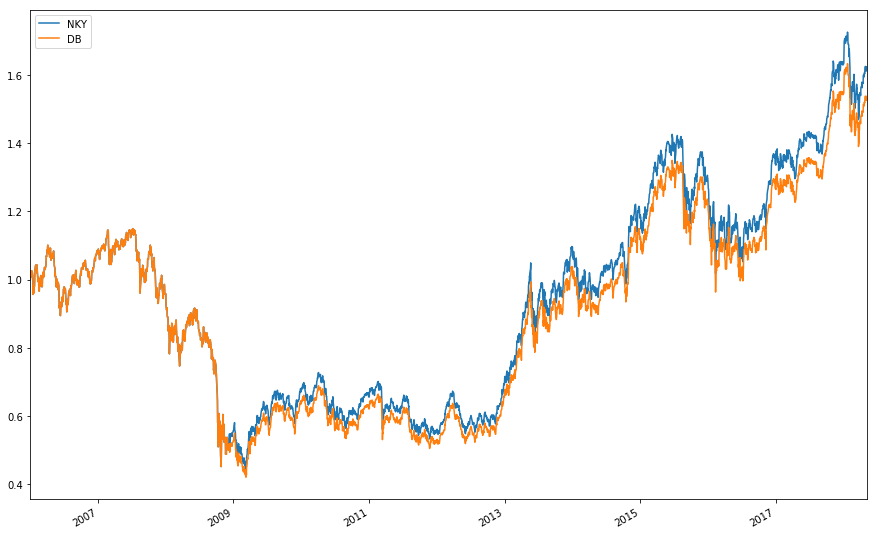

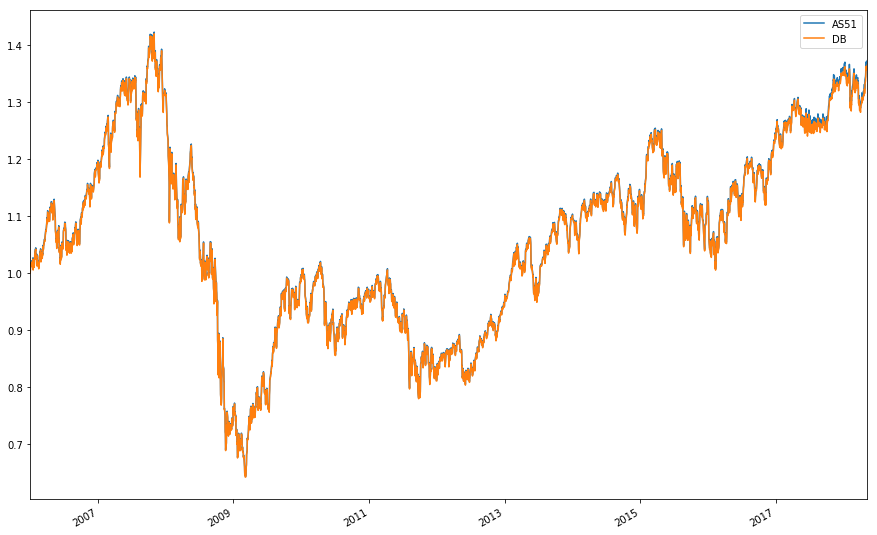

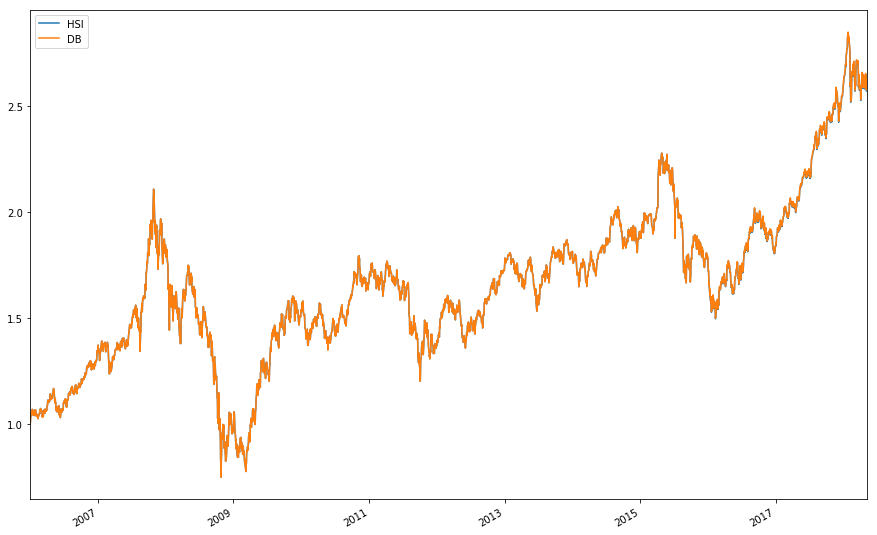

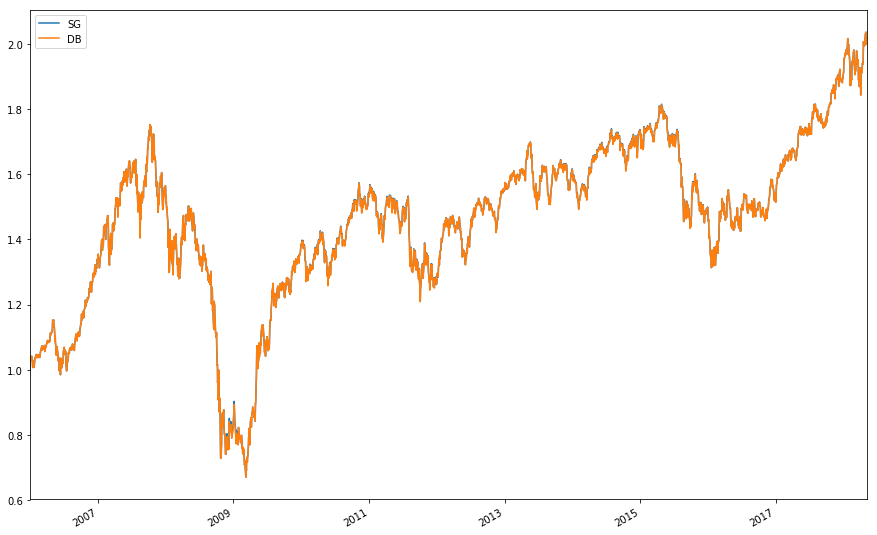

In [32]:
r_data = (1.+ ERet.loc[start_date:end_date]).cumprod()
db_data = (1.+ edy.ret.loc[start_date:end_date]).cumprod()

for column in Eindex.columns:
    toplot = r_data[column].to_frame()
    toplot['DB'] = db_data[column]
#     toplot['DIFF'] = toplot[column] - toplot['DB']
    toplot.plot(figsize=(15,10), secondary_y='DIFF')

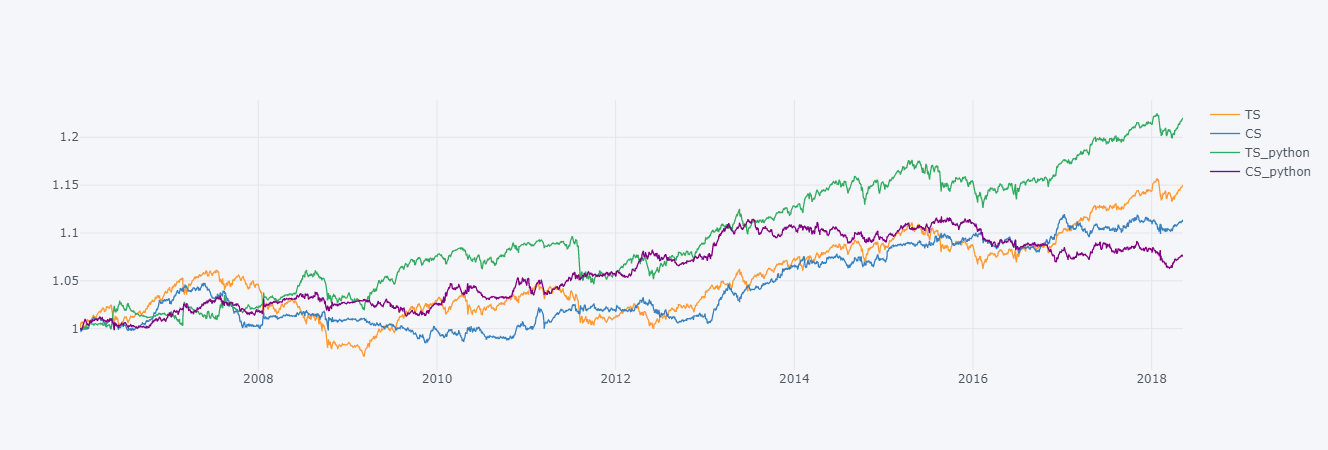

In [16]:
to_plot = (1.+ edy_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# 3. EFX

In [17]:
efx = EFX(strategy_name="EFX", asset_type="EQUITY")
efx.load_index_and_return(from_db=True, save_file=True)
efx.load_strategy_data(table='bloom', origin='fx')
efx.set_rebalance_period(ts_freq='month', cs_freq='month')
efx.calculate_signal(minobs1=12, nopos=0.4, CS=0.35, longlen=12, shortlen=0, SDEV=12)
efx.set_portfolio_parameter(cs_strategy_type='notional')
efx.make_portfolio()

2020-01-22 15:03:21,177 - EFX - INFO - [STEP 0] START LOGGING EFX
2020-01-22 15:03:21,177 - EFX - INFO - [STEP 0] START LOGGING EFX
2020-01-22 15:03:21,180 - EFX - INFO - [STEP 1] LOAD DATA
2020-01-22 15:03:21,180 - EFX - INFO - [STEP 1] LOAD DATA
2020-01-22 15:03:21,181 - EFX - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-01-22 15:03:21,181 - EFX - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-01-22 15:03:21,184 - EFX - INFO - [STEP 1 - 3 ] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-01-22 15:03:21,184 - EFX - INFO - [STEP 1 - 3 ] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-01-22 15:03:23,221 - EFX - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-01-22 15:03:23,221 - EFX - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-01-22 15:03:24,836 - EFX - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-01-22 15:03:24,836 - EFX - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-01-22 15:03:57,311 - EFX - INFO - [STEP 1 -

### PAST

In [18]:
start_date = '2001-01-01'
end_date = '2018-05-09'

# get r results
efx_comp_df = pd.read_csv('./past/efx.csv', header=0, index_col=0, parse_dates=True)
efx_lag_comp_df = pd.read_csv('./past/efx_lag.csv', header=0, index_col=0, parse_dates=True)

In [19]:
tester = Tester(efx)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False)

2020-01-22 15:06:58,198 - EFX - INFO - [STEP 6] START BACKTEST
2020-01-22 15:06:58,198 - EFX - INFO - [STEP 6] START BACKTEST
2020-01-22 15:06:58,200 - EFX - INFO - [STEP 6 - 1] BACKTEST EFX TIME SERIES
2020-01-22 15:06:58,200 - EFX - INFO - [STEP 6 - 1] BACKTEST EFX TIME SERIES


EFX
0% [############################# ] 100% | ETA: 00:00:00

2020-01-22 15:07:07,178 - EFX - INFO - [STEP 6 - 2] BACKTEST EFX CROSS SECTIONAL
2020-01-22 15:07:07,178 - EFX - INFO - [STEP 6 - 2] BACKTEST EFX CROSS SECTIONAL


EFX
0% [############################# ] 100% | ETA: 00:00:00

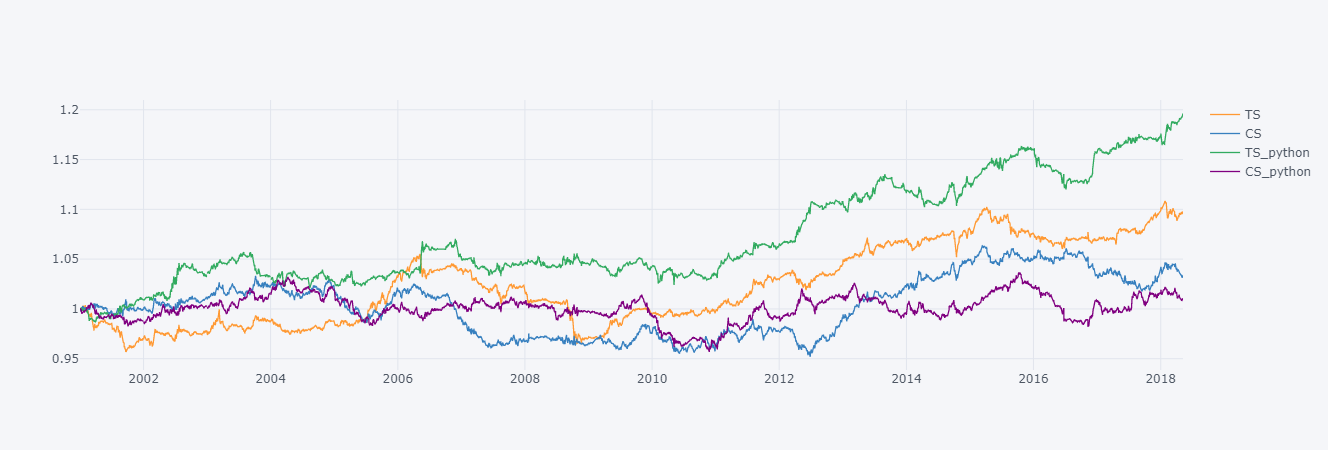

In [20]:
to_plot = (1.+ efx_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# 4. ELQ

In [ ]:
elq = ELQ(strategy_name="ELQ", asset_type="EQUITY")
elq.load_index_and_return(from_db=True, save_file=True)
elq.load_strategy_data(table='CEIC', origin='m2gdp')

elq.set_rebalance_period(ts_freq='month', cs_freq='month')
elq.calculate_signal(minobs1=12, nopos=0.4, CS=0.35, longlen=6, shortlen=0)
elq.set_portfolio_parameter(cs_strategy_type='notional')
elq.make_portfolio()

In [ ]:
start_date = '2001-01-01'
end_date = '2018-05-09'

# get r results
elq_comp_df = pd.read_csv('./past/elq.csv', header=0, index_col=0, parse_dates=True)
elq_lag_comp_df = pd.read_csv('./past/elq_lag.csv', header=0, index_col=0, parse_dates=True)

In [ ]:
tester = Tester(elq)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False)

In [ ]:
to_plot = (1.+ elq_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# 5. EPE

In [ ]:
epe = EPE(strategy_name="EPE", asset_type="EQUITY")
epe.load_index_and_return(from_db=True, save_file=True)
epe.load_strategy_data(table='DS', origin1='EPS', origin2='EPS1')

epe.set_rebalance_period(ts_freq='month', cs_freq='month')
epe.calculate_signal(minobs1=12, nopos=0.4, CS=0.35)
epe.set_portfolio_parameter(cs_strategy_type='notional')
epe.make_portfolio()

In [ ]:
start_date = '2001-01-01'
end_date = '2018-05-09'

# get r results
epe_comp_df = pd.read_csv('./past/epe.csv', header=0, index_col=0, parse_dates=True)
epe_lag_comp_df = pd.read_csv('./past/epe_lag.csv', header=0, index_col=0, parse_dates=True)

In [ ]:
tester = Tester(epe)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False)

In [ ]:
to_plot = (1.+ epe_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# 6. EPM

In [ ]:
epm = EPM(strategy_name="EPM", asset_type="EQUITY")
epm.load_index_and_return(from_db=True, save_file=True)
epm.load_strategy_data(table='datastream', origin='EPS')
epm.set_rebalance_period(ts_freq='week', cs_freq='month', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6
epm.calculate_signal(minobs1=52, longlen=52, longlen2=13, shortlen=2, CS=0.35)
epm.set_portfolio_parameter(cs_strategy_type='notional')
epm.make_portfolio()

In [ ]:
start_date = '2001-01-01'
end_date = '2018-05-09'

# get r results
epm_comp_df = pd.read_csv('./past/epm.csv', header=0, index_col=0, parse_dates=True)
epm_lag_comp_df = pd.read_csv('./past/epm_lag.csv', header=0, index_col=0, parse_dates=True)

In [ ]:
tester = Tester(epm)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False)

In [ ]:
to_plot = (1.+ epm_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# 7. EQL

In [ ]:
eql = EQL(strategy_name="EQL", asset_type="EQUITY")
eql.load_index_and_return(from_db=True, save_file=True)
eql.load_strategy_data(table='FS', origin1='ROA', origin2='ICR')
eql.set_rebalance_period(ts_freq='month', cs_freq='month')  # rebalance_day: monday = 0, sunday = 6
eql.calculate_signal(minobs1=12, nopos=0.4, CS=0.35, lag=1)
eql.set_portfolio_parameter(cs_strategy_type="notional")
eql.make_portfolio()

In [ ]:
start_date = '2006-01-01'
end_date = '2018-05-09'

# get r results
eql_comp_df = pd.read_csv('./past/eql.csv', header=0, index_col=0, parse_dates=True)
eql_lag_comp_df = pd.read_csv('./past/eql_lag.csv', header=0, index_col=0, parse_dates=True)

In [ ]:
tester = Tester(eql)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False)

In [ ]:
to_plot = (1.+ eql_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# 8. EST

In [ ]:
est = EST(strategy_name="EST", asset_type="EQUITY")
est.load_index_and_return(from_db=True, save_file=True)
est.load_strategy_data(table='FS', origin='growthvalue')
est.set_rebalance_period(ts_freq='month', cs_freq='month')  # rebalance_day: monday = 0, sunday = 6
est.calculate_signal(minobs1=12, nopos=0.4, CS=0.35, per=3)
est.set_portfolio_parameter(cs_strategy_type="notional")
est.make_portfolio()

In [ ]:
start_date = '2006-01-01'
end_date = '2018-05-09'

# get r results
est_comp_df = pd.read_csv('./past/est.csv', header=0, index_col=0, parse_dates=True)
est_lag_comp_df = pd.read_csv('./past/est_lag.csv', header=0, index_col=0, parse_dates=True)

In [ ]:
tester = Tester(est)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False)

In [ ]:
to_plot = (1.+ est_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# 9. EVO

In [ ]:
evo = EVO(strategy_name="EVO", asset_type="EQUITY")
evo.load_index_and_return(from_db=True, save_file=True)
evo.load_strategy_data(table='bloom', origin='ivol')
evo.set_rebalance_period(ts_freq='month', cs_freq='month')
evo.calculate_signal(minobs1=12, nopos=0.4, CS=0.35)
evo.set_portfolio_parameter(cs_strategy_type="notional")
evo.make_portfolio()

In [ ]:
start_date = '2001-01-01'
end_date = '2018-05-09'

# get r results
evo_comp_df = pd.read_csv('./past/evo.csv', header=0, index_col=0, parse_dates=True)
evo_lag_comp_df = pd.read_csv('./past/evo_lag.csv', header=0, index_col=0, parse_dates=True)

In [ ]:
tester = Tester(evo)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False)

In [ ]:
to_plot = (1.+ evo_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# 10. ESS

In [ ]:
strategy = ESS(strategy_name="ESS", asset_type="EQUITY")
strategy.load_index_and_return(from_db=True, save_file=True)
strategy.set_rebalance_period(ts_freq='day', cs_freq = 'month')
strategy.calculate_signal(short=0.2, day1=24, CS=0.35, statwgt=1, fundwgt=1)
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

In [ ]:
start_date = '2001-01-01'
end_date = '2018-05-09'

# get r results
ess_comp_df = pd.read_csv('./past/ess.csv', header=0, index_col=0, parse_dates=True)
ess_lag_comp_df = pd.read_csv('./past/ess_lag.csv', header=0, index_col=0, parse_dates=True)

In [ ]:
# to_plot = (1.+ ess_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()